# Plot All Shift with Severity 5

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tta.data.cifar import Cifar10CDataset
from tta.data.dataloader import build_test_loader
from tta.method.source import Source

method = Source()
model = method.model
device = "mps"

entropy_values_per = {}
gradient_norms_per = {}

for i in range(1, 6):
    dataset = Cifar10CDataset(
        num_samples=500, corrupt_domain_orders=["gaussian_noise"], severity=i
    )
    data_loader = build_test_loader(dataset, batch_size=1)

    # Assume you have a trained model and some input data
    model.eval()

    entropy_values = []
    gradient_norms = []

    for batch in data_loader:  # single sample or batch size = 1
        input_sample, label, _ = batch
        input_sample = input_sample.to(device).requires_grad_(True)

        # Forward pass
        output = model(input_sample)
        probs = F.softmax(output, dim=1)

        # Compute entropy
        log_probs = torch.log(probs + 1e-12)
        entropy = -torch.sum(probs * log_probs, dim=1)  # entropy per sample
        entropy_values.append(entropy.item())

        # Use entropy (or max logit) as pseudo-loss to compute gradients
        pseudo_loss = entropy.sum()
        pseudo_loss.backward(retain_graph=True)

        # Compute gradient norm w.r.t. input
        grad = input_sample.grad.detach()
        grad_norm = torch.norm(grad, p=2)  # L2 norm
        gradient_norms.append(grad_norm.item())

        model.zero_grad()
    entropy_values_per[i] = entropy_values
    gradient_norms_per[i] = gradient_norms

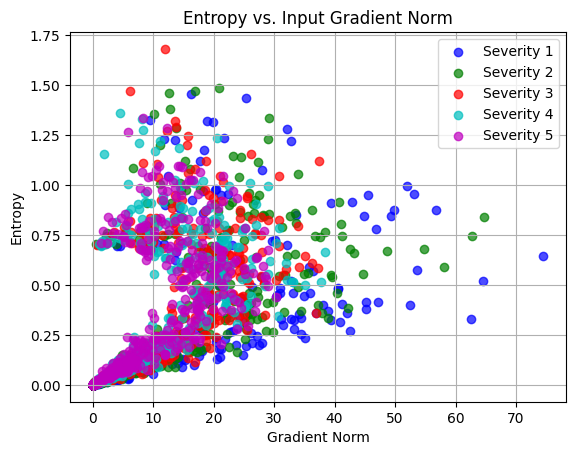

In [ ]:
colors = ["b", "g", "r", "c", "m"]  # Define a list of colors for different values of i

for i in range(1, 6):
    plt.scatter(
        gradient_norms_per[i],
        entropy_values_per[i],
        color=colors[i - 1],
        label=f"Severity {i}",
        alpha=0.7,
    )

plt.xlabel("Gradient Norm")
plt.ylabel("Entropy")

plt.title("Entropy vs. Input Gradient Norm")
plt.legend()
plt.grid(True)
plt.show()

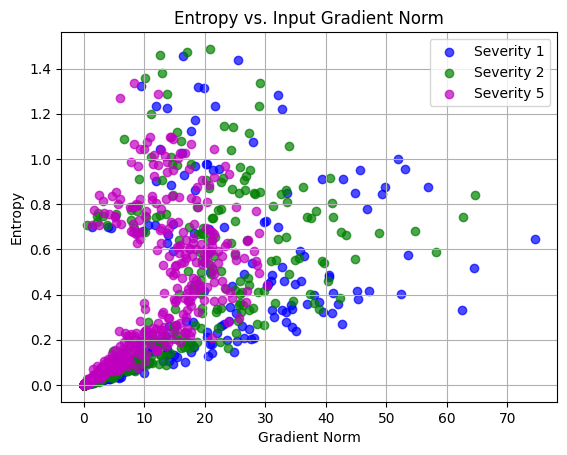

In [ ]:
colors = ["b", "g", "r", "c", "m"]  # Define a list of colors for different values of i

for i in [1, 2, 5]:
    plt.scatter(
        gradient_norms_per[i],
        entropy_values_per[i],
        color=colors[i - 1],
        label=f"Severity {i}",
        alpha=0.7,
    )

plt.xlabel("Gradient Norm")
plt.ylabel("Entropy")

plt.title("Entropy vs. Input Gradient Norm")
plt.legend()
plt.grid(True)
plt.show()